In [ ]:
!pip install transformers
!pip install wordcloud
!pip install scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW

In [ ]:
# Load your CSV dataset
data = pd.read_csv('label_data.csv')  # Update this path if needed

# Clean tweets
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"@\S+", "", tweet)
    tweet = re.sub(r"#\S+", "", tweet)
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    return tweet.lower().strip()

data['cleaned_tweet'] = data['tweet'].apply(clean_tweet)


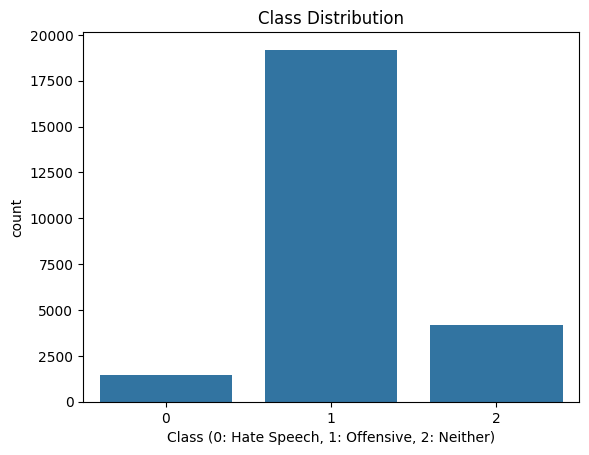

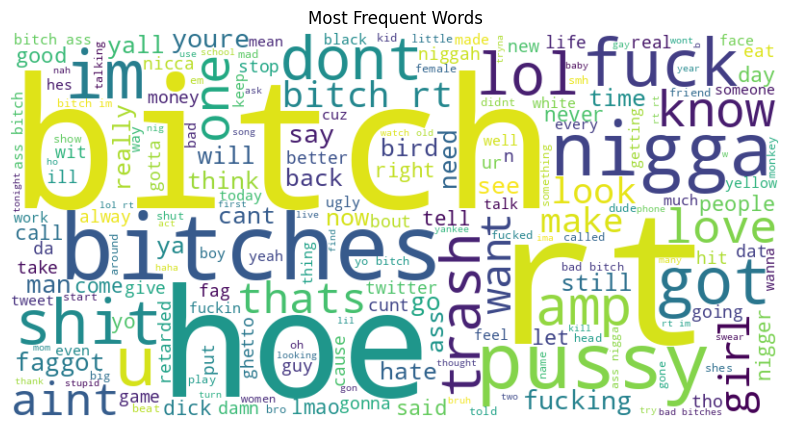

In [ ]:
# Plot class distribution
sns.countplot(x='class', data=data)
plt.title("Class Distribution")
plt.xlabel("Class (0: Hate Speech, 1: Offensive, 2: Neither)")
plt.show()

# WordCloud
text = ' '.join(data['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words")
plt.show()


In [ ]:
X = data['cleaned_tweet']
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# ML Model
ml_model = LogisticRegression(max_iter=1000)
ml_model.fit(X_train_vec, y_train)

# Evaluation
y_pred_ml = ml_model.predict(X_test_vec)
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ml))
print(classification_report(y_test, y_pred_ml))


Logistic Regression Results:
Accuracy: 0.8876336493847085
              precision    recall  f1-score   support

           0       0.49      0.15      0.23       290
           1       0.91      0.96      0.93      3832
           2       0.83      0.81      0.82       835

    accuracy                           0.89      4957
   macro avg       0.74      0.64      0.66      4957
weighted avg       0.87      0.89      0.87      4957



In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(texts):
    return tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=64,
        return_tensors='pt'
    )

train_encodings = tokenize(X_train)
test_encodings = tokenize(X_test)

train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

train_dataset = TensorDataset(train_encodings['input_ids'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Train for 1 epoch (adjust if needed)
for epoch in range(1):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1 Loss: 0.3084


In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, true = [], []
    for batch in loader:
        input_ids, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        preds.extend(predictions.cpu().numpy())
        true.extend(labels.cpu().numpy())
    return preds, true

bert_preds, bert_true = evaluate(model, test_loader)
print("DistilBERT Results:")
print("Accuracy:", accuracy_score(bert_true, bert_preds))
print(classification_report(bert_true, bert_preds))


DistilBERT Results:
Accuracy: 0.898930804922332
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       290
           1       0.95      0.93      0.94      3832
           2       0.83      0.91      0.87       835

    accuracy                           0.90      4957
   macro avg       0.73      0.76      0.74      4957
weighted avg       0.90      0.90      0.90      4957



In [ ]:
def predict_new_tweet(tweet):
    tweet_clean = clean_tweet(tweet)
    enc = tokenizer(tweet_clean, return_tensors='pt', truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        output = model(**enc)
    pred = torch.argmax(output.logits, dim=1).item()
    label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
    return label_map[pred]

# Try a new tweet
sample_tweet = "I can't stand those people anymore!"
print("Prediction for new tweet:", predict_new_tweet(sample_tweet))


Prediction for new tweet: Neither


In [ ]:
# Try a new tweet
sample_tweet = input("Enter a tweet to classify: ")
print("Prediction for new tweet:", predict_new_tweet(sample_tweet))

Enter a tweet to classify: hey u r a bitch
Prediction for new tweet: Offensive Language


Shape of the dataset: (24783, 7)

First 5 rows:


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB

Missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64


<ipython-input-18-b65db4751834>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette='Set2')


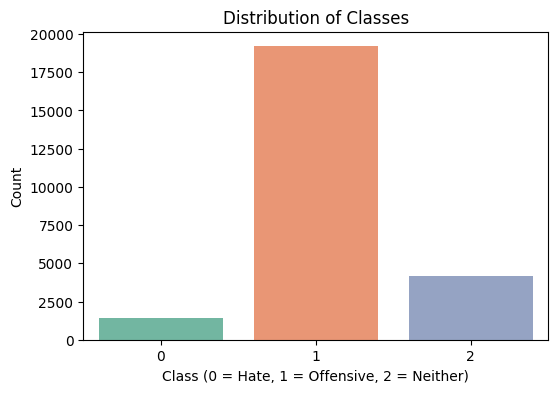

Hate Speech: 1430 tweets
Offensive Language: 19190 tweets
Neither: 4163 tweets


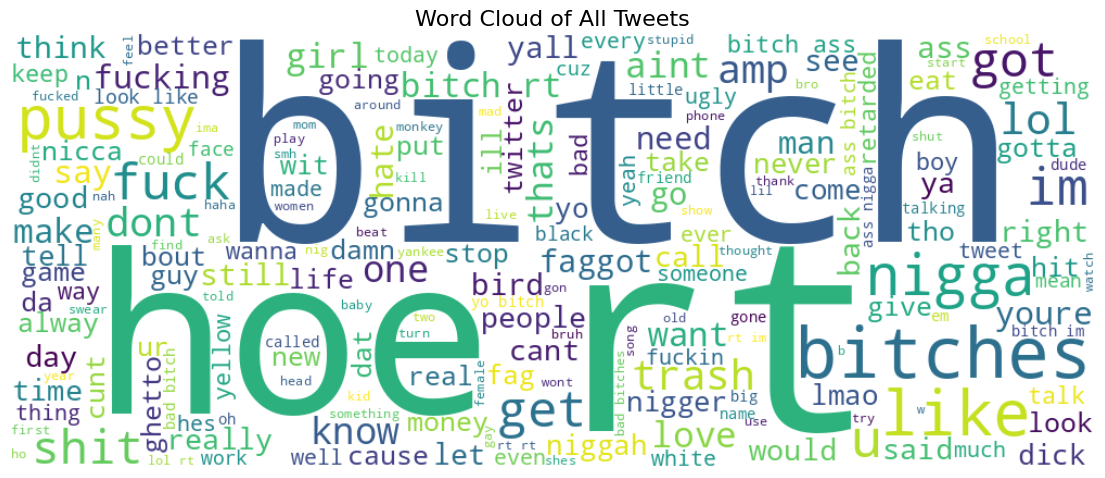

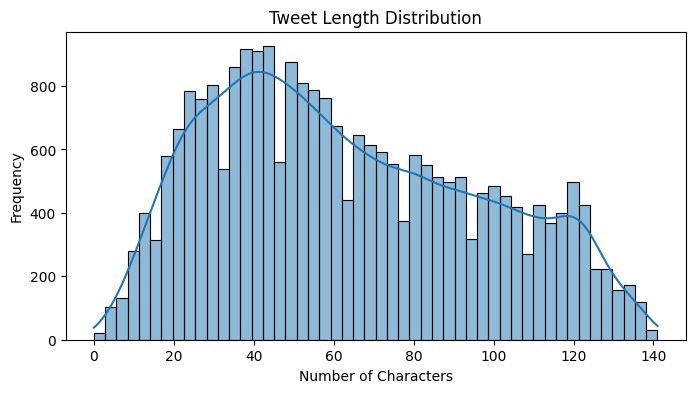

<ipython-input-18-b65db4751834>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='tweet_length', data=df, palette='Set3')


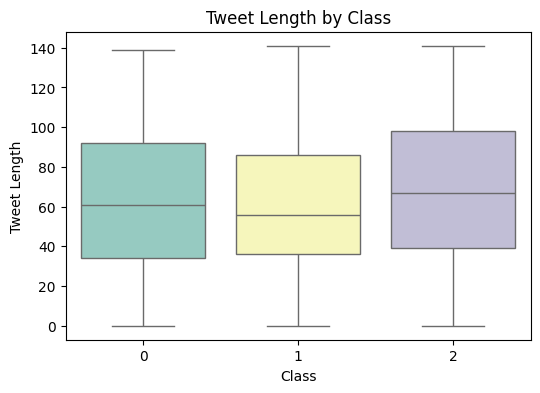

<ipython-input-18-b65db4751834>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


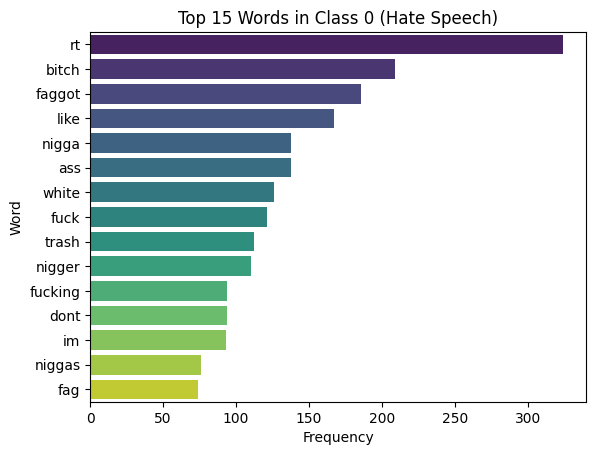

<ipython-input-18-b65db4751834>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


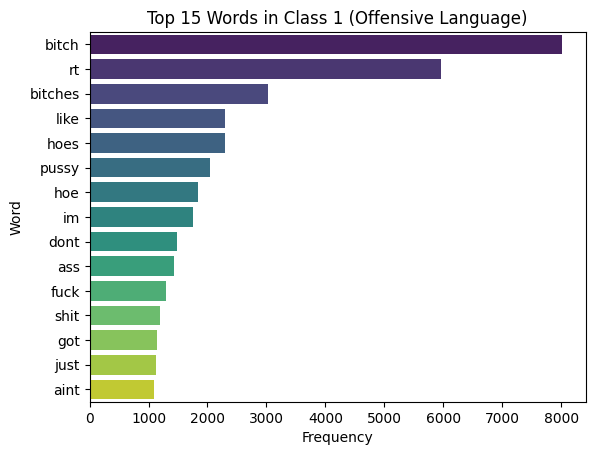

<ipython-input-18-b65db4751834>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


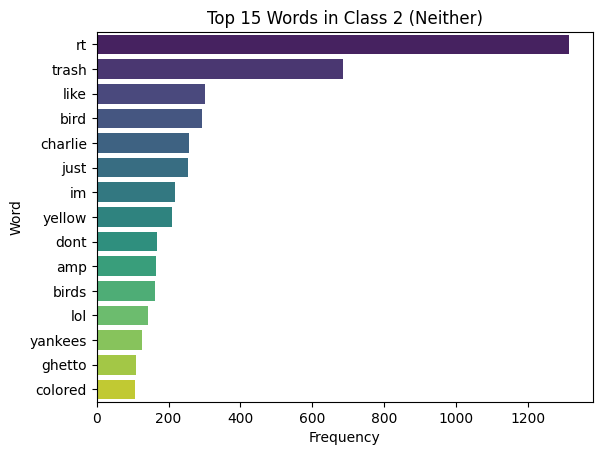

In [ ]:
#EDA Optional
# 📦 Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# 🚀 Load the data
df = pd.read_csv('label_data.csv')  # Change the path if needed

# 👀 Preview the data
print("Shape of the dataset:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# 📄 Dataset Info
print("\nDataset Info:")
df.info()

# 🧼 Missing Values
print("\nMissing values:")
print(df.isnull().sum())

# 📊 Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, palette='Set2')
plt.title("Distribution of Classes")
plt.xlabel("Class (0 = Hate, 1 = Offensive, 2 = Neither)")
plt.ylabel("Count")
plt.show()

# 🔢 Count of each class
class_names = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
class_counts = df['class'].value_counts().sort_index()
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count} tweets")

# 🧹 Clean tweets (if not already)
import re, string
def clean_tweet(text):
    text = re.sub(r"http\S+|@\S+|#\S+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.lower().strip()

df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

# ☁️ Word Cloud
text_all = " ".join(df['cleaned_tweet'])
wordcloud = WordCloud(width=1000, height=400, background_color='white', stopwords=set(stopwords.words('english'))).generate(text_all)

plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Tweets", fontsize=16)
plt.show()

# 📈 Tweet length analysis
df['tweet_length'] = df['cleaned_tweet'].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(df['tweet_length'], bins=50, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

# 📊 Class-wise average tweet length
plt.figure(figsize=(6,4))
sns.boxplot(x='class', y='tweet_length', data=df, palette='Set3')
plt.title("Tweet Length by Class")
plt.xlabel("Class")
plt.ylabel("Tweet Length")
plt.show()

# 🔤 Most Common Words by Class
from sklearn.feature_extraction.text import CountVectorizer

def show_top_n_words(class_label, n=15):
    subset = df[df['class'] == class_label]
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(subset['cleaned_tweet'])
    sum_words = words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:n]

    words_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
    sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
    plt.title(f"Top {n} Words in Class {class_label} ({class_names[class_label]})")
    plt.show()

# Show top words for each class
for i in range(3):
    show_top_n_words(i)
